# Project: Data from Web Scraping (Xrates)

<br>

## Questions to address:
- Access the conversion rates on Xrates website using Web scraping
- Get the conversion rate between two currencies
- get a list of all currencies
- Plot the evolution of the Exchange rate of EUR against GBP

<br>

## Tools:
- list(set(currency_list))
- requests.get(), response.content, BeautifulSoup(content,'html.parser')
- string operations
- format plotting of dates
  - mdates.DayLocator(bymonthday=[1,]), mdates.DateFormatter('%Y-%m-%d')
- fourier transform analysis of time variation

<br>

### load defaults

In [117]:
import pandas as pd
import re
import numpy as np
import requests 
from bs4 import BeautifulSoup

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

## Inputs:

In [6]:
current_dir = '/Users/BrunoHenriques/Desktop/OneDrive/Workspace_bitbucket/datascience/Web_scraping'

<br>

## Dataset: Currency exchange data from X-rates

### get the current GBP to Euro conversion rate

In [27]:
#GBP to EURO current
response = requests.get('http://www.x-rates.com/calculator/?from=GBP&to=EUR&amount=1')
content = response.content
parser = BeautifulSoup(content,'html.parser')

xrate = parser.select('.ccOutputRslt')
print(xrate[0].text)

1.127900 EUR


### Get a list of all currencies

In [48]:
#Any date and currency will do (use GBP)
date='2017-10-16'
response = requests.get('http://www.x-rates.com/historical/?from=GBP&amount=1&date='+date)
content = response.content
parser = BeautifulSoup(content,'html.parser')

#this will have a name and conversion between GBP and all other currencies
xrate = parser.select('a[href*="/graph/?from"]')

#extract the names of other currencies
currency_list = []
for element in xrate:       
    text = re.sub('.*from=','', element['href'])    
    text = re.sub('&to=',' ', text)    
    if(re.match('^GBP', text)): 
        currency_list.append(re.sub('GBP ','', text))
currency_list.append('GBP')

#append the use set to get the unique values then convert back to list    
print(list(set(currency_list)))    

['KWD', 'VEF', 'BGN', 'CAD', 'MUR', 'SAR', 'INR', 'NZD', 'GBP', 'HRK', 'ISK', 'LYD', 'SGD', 'BRL', 'DKK', 'MXN', 'HKD', 'PHP', 'CHF', 'PLN', 'RON', 'BHD', 'CLP', 'SEK', 'USD', 'IRR', 'QAR', 'HUF', 'IDR', 'MYR', 'BWP', 'RUB', 'ARS', 'OMR', 'ZAR', 'AED', 'AUD', 'CNY', 'BND', 'KRW', 'THB', 'NPR', 'EUR', 'TWD', 'COP', 'JPY', 'ILS', 'CZK', 'PKR', 'NOK', 'TRY', 'KZT', 'TTD', 'LKR']


### Get historical data on a conversion rate between one currency and all others

In [51]:
currency = 'EUR'
date = pd.date_range(start='01/01/2018', end='09/30/2018', freq='d')    

date = [str(element.date()) for element in date]
df_currency_list = pd.Series(currency_list)
df_currency_list = df_currency_list[~df_currency_list.duplicated(keep='first')]
df_currency_list = df_currency_list.reset_index(drop=True)

df = pd.DataFrame(np.zeros((len(date), len(df_currency_list))), index=date, columns=df_currency_list)

for idx, xx in enumerate(date):
    if(idx%100==0):
        print('doing day %d of %d\n' % (idx, len(date)))    
    response = requests.get('http://www.x-rates.com/historical/?from='+currency+'&amount=1&date='+xx)
    content = response.content
    parser = BeautifulSoup(content,'html.parser')

    xrate = parser.select('.tablesorter')
    xrate = parser.select('a[href*="/graph/?from"]')
    
    for yy in xrate:
        text = re.sub('.*from=','', yy['href'])
        text = re.sub('&to=',' ', text)
        if(re.match('^'+currency, text)):        
            target_currency = (re.sub(currency+' ','', text))
            df.loc[xx][target_currency] = yy.text
        
#write data
df.to_csv(current_dir+'/xrates_data/'+currency+'.csv', header=True)

print('\n\nDONE')

doing day 0 of 273

doing day 100 of 273

doing day 200 of 273



DONE


## Analysis


### Read data previously written into a file

In [85]:
currency = 'EUR'
df = pd.read_csv(current_dir+'/xrates_data/'+currency+'.csv', index_col=0)
display(df[:2])

,USD,EUR,INR,AUD,CAD,SGD,CHF,MYR,JPY,CNY,...,ZAR,LKR,SEK,TWD,THB,TTD,TRY,AED,VEF,GBP
2018-01-01,1.200032,0.0,76.603011,1.537060,1.515334,1.605735,1.169711,4.872860,135.224776,7.808298,...,14.847453,184.193430,9.835555,35.624019,39.072638,8.117224,4.552984,4.407119,11.985322,0.889247
2018-01-02,1.204816,0.0,76.458568,1.540019,1.506905,1.601534,1.171029,4.842998,135.165665,7.822875,...,14.994892,184.999339,9.848623,35.646183,39.101796,8.152989,4.538910,4.424685,12.033096,0.886353


<br>

### Q1: Plot the evolution of the conversion rate between EUR and GBP

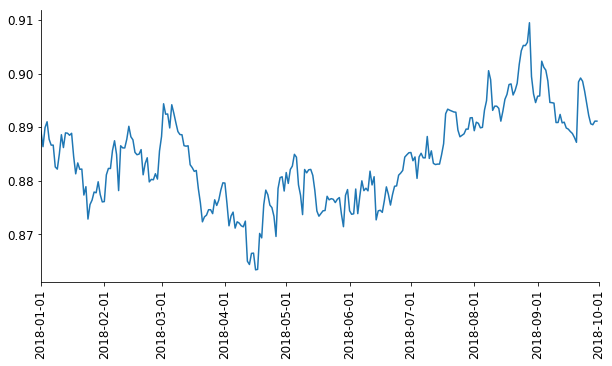

In [172]:
date = pd.to_datetime(df.index)
start_date = '2018-01-01'
end_date = '2018-10-01'

date = date[(date>=start_date) & (date<=end_date)]


fig = plt.figure(figsize=(10,5))
ax = plt.subplot()


ax.plot(date, df['GBP'].loc[start_date: end_date].values)

#format date axis
days_locator = mdates.DayLocator(bymonthday=[1,])
ax.xaxis.set_major_locator(days_locator)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax.tick_params(axis='x', rotation=90)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([start_date, end_date])

plt.show()

<br>

### Q2: Fourier Analysis of the time variation

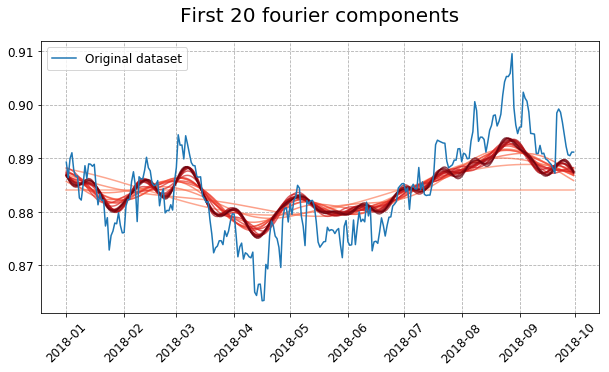

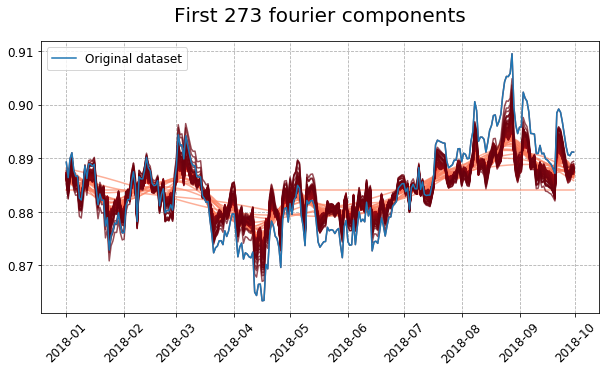

In [219]:
from scipy.fftpack import fft, ifft
from scipy import zeros

y = df['GBP'].loc[start_date: end_date].values
x = date

n = len(y)
COMPONENTS = [20, n]


#ax = plt.subplot()

for c in COMPONENTS:
    fig = plt.figure(figsize=(10,5))
    colors = np.linspace(start=100, stop=255, num=c)
    for i in range(c):
        #Compute the one-dimensional discrete Fourier Transform
        Y = np.fft.fft(y)
        #replace all Fourier components above c with 0
        np.put(Y, range(i+1, n), 0.0)
        #Compute the one-dimensional inverse discrete Fourier Transform
        ifft = np.fft.ifft(Y)
        plt.plot(x, ifft, color=plt.cm.Reds(int(colors[i])), alpha=.70)

    plt.tick_params(axis='x', rotation=45)      
    plt.title("First %d fourier components" %(c))
    plt.plot(x,y, label="Original dataset")
    plt.grid(linestyle='dashed')
    plt.legend()
    plt.show()

<br>

### Q3: Look only at Fourier components 10, 20 and 30

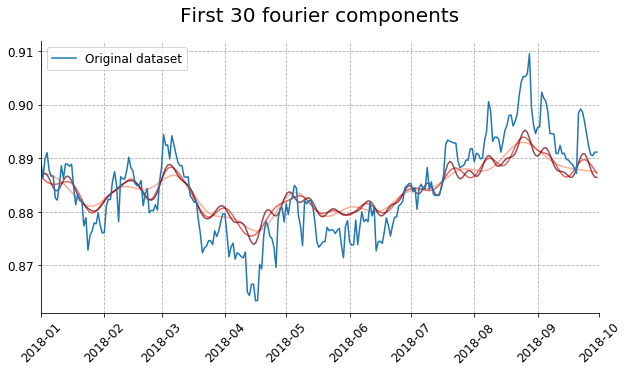

In [215]:
y = df['GBP'].loc[start_date: end_date].values
x = date

n = len(y)
COMPONENTS = [10, 20, 30]
#COMPONENTS = [30]

fig = plt.figure(figsize=(10,5))
ax = plt.subplot()

jj = 0
for c in COMPONENTS:
    colors = np.linspace(start=100, stop=255, num=len(COMPONENTS))
    #Compute the one-dimensional discrete Fourier Transform
    Y = np.fft.fft(y)
    #replace all Fourier components above c with 0
    np.put(Y, range(c+1, n), 0.0)
    #Compute the one-dimensional inverse discrete Fourier Transform
    ifft = np.fft.ifft(Y)
    ax.plot(x, ifft, color=plt.cm.Reds(int(colors[jj])), alpha=.70)
    jj+=1
    
ax.tick_params(axis='x', rotation=45)  

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlim([start_date, end_date])

plt.title("First %d fourier components" %(c))
plt.plot(x,y, label="Original dataset")
plt.grid(linestyle='dashed')
plt.legend()
plt.show()

<br>

### Q4: look at the characteristic time for changes in the slope

In [222]:
def get_slope_changes(x,y):
    
    xx = []
    yy = []
    aux_y = y[0].real

    if (y[0].real>y[1].real):
        flag = 1
    else:
        flag = -1
    
    for ii in range(1, len(x)):    
        if (flag == 1) & (y[ii].real<y[ii-1].real):        
            xx.append(x[ii])
            yy.append(y[ii].real)
            flag=-1
        
        if (flag == -1) & (y[ii].real>y[ii-1].real):      
            xx.append(x[ii])
            yy.append(y[ii].real)
            flag=1
    
    return xx, yy

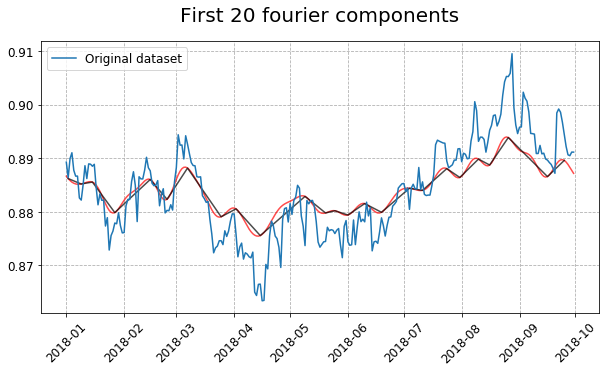

delta_t = 5: 1
delta_t = 6: 2
delta_t = 7: 4
delta_t = 8: 1
delta_t = 9: 4
delta_t = 10: 2
delta_t = 11: 2
delta_t = 12: 1
delta_t = 13: 2
delta_t = 15: 1
delta_t = 18: 1
delta_t = 19: 1
delta_t = 21: 1
delta_t = 24: 1


In [223]:
from datetime import timedelta

c = 20
n = len(y)
x = date

#Compute the one-dimensional discrete Fourier Transform
Y = np.fft.fft(y)
#replace all Fourier components above c with 0
np.put(Y, range(c+1, n), 0.0)
#Compute the one-dimensional inverse discrete Fourier Transform
ifft = np.fft.ifft(Y)

xx, yy = get_slope_changes(x,ifft)
 

fig = plt.figure(figsize=(10,5))
ax = plt.subplot()

ax.plot(x, ifft, color='red', alpha=.70) 
ax.plot(xx, yy, color='black', alpha=.70) 
ax.tick_params(axis='x', rotation=45)    
plt.title("First {c} fourier components".format(c=c))
plt.plot(x,y, label="Original dataset")
plt.grid(linestyle='dashed')
plt.legend()
plt.show()   

time_delta = []
for ii in range(1,len(xx)):    
    time_delta.append((xx[ii]-xx[ii-1]).days)
    
values, counts = np.unique(time_delta, return_counts=True)

for ii in range(0,len(counts)):
    print("delta_t = %d: %d" % (values[ii], counts[ii]))